# util    

In [6]:
import importlib.util
import sys

from pytorch_lightning.callbacks.progress import ProgressBar

# check if ipywidgets is installed before importing tqdm.auto
# to ensure it won't fail and a progress bar is displayed
if importlib.util.find_spec("ipywidgets") is not None:
    from tqdm.auto import tqdm
else:
    from tqdm import tqdm


class GlobalProgressBar(ProgressBar):
    def __init__(self, process_position: int = 0):
        super().__init__()
        self._process_position = process_position
        self._enabled = True
        self.main_progress_bar = None

    def __getstate__(self):
        # can't pickle the tqdm objects
        state = self.__dict__.copy()
        state["main_progress_bar"] = None
        return state

    @property
    def process_position(self) -> int:
        return self._process_position

    def disable(self) -> None:
        self._enabled = False

    def enable(self) -> None:
        self._enabled = True

    def on_train_start(self, trainer, pl_module):
        super().on_train_start(trainer, pl_module)
        self.main_progress_bar = tqdm(
            desc="Total Epochs",
            initial=trainer.current_epoch,
            total=trainer.max_epochs,
            position=(2 * self.process_position),
            disable=False,
            leave=True,
            dynamic_ncols=True,
            file=sys.stdout,
            smoothing=0,
        )

    def on_train_end(self, trainer, pl_module):
        self.main_progress_bar.close()

    def on_epoch_end(self, trainer, pl_module):
        self.main_progress_bar.update(1)


# train


In [7]:
import dgl
from dgl.data import FraudDataset

dataset = FraudDataset("yelp")
g = dataset[0]
print(g.etypes)
print(g.ntypes)
print(g.ndata)
print(g.ndata.keys())
print()
print(g.ndata["feature"])


Done loading data from cached files.
['net_rsr', 'net_rtr', 'net_rur']
['review']
{'val_mask': tensor([1, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8), 'test_mask': tensor([0, 0, 0,  ..., 1, 0, 0], dtype=torch.uint8), 'train_mask': tensor([0, 1, 1,  ..., 0, 1, 1], dtype=torch.uint8), 'label': tensor([0, 0, 0,  ..., 0, 0, 0]), 'feature': tensor([[0.0224, 0.0705, 0.4287,  ..., 0.5920, 0.1393, 0.4975],
        [0.0249, 1.0000, 1.0000,  ..., 0.5920, 0.1393, 0.4975],
        [0.0062, 0.0705, 0.4287,  ..., 0.5920, 0.1393, 0.4975],
        ...,
        [0.0091, 0.3500, 0.4287,  ..., 0.4826, 0.8010, 0.1642],
        [0.0062, 0.0705, 1.0000,  ..., 0.4428, 0.4478, 0.5871],
        [0.0032, 0.3500, 0.4287,  ..., 0.4428, 0.4478, 0.5871]])}
dict_keys(['val_mask', 'test_mask', 'train_mask', 'label', 'feature'])

tensor([[0.0224, 0.0705, 0.4287,  ..., 0.5920, 0.1393, 0.4975],
        [0.0249, 1.0000, 1.0000,  ..., 0.5920, 0.1393, 0.4975],
        [0.0062, 0.0705, 0.4287,  ..., 0.5920, 0.1393, 0.4975],
  

In [8]:
mask = g.ndata["train_mask"].to(bool)
l = {0: 0, 1: 0}

for x in g.ndata["label"][mask].numpy():
    l[x] += 1
print(l, l[0] / (mask.sum()))

mask = g.ndata["val_mask"].to(bool)
l = {0: 0, 1: 0}

for x in g.ndata["label"][mask].numpy():
    l[x] += 1
print(l, l[0] / (mask.sum()))

mask = g.ndata["test_mask"].to(bool)
l = {0: 0, 1: 0}

for x in g.ndata["label"][mask].numpy():
    l[x] += 1
print(l, l[0] / (mask.sum()))


{0: 27441, 1: 4726} tensor(0.8531)
{0: 3944, 1: 651} tensor(0.8583)
{0: 7892, 1: 1300} tensor(0.8586)


In [9]:
import torch
from torch.nn import functional as F
import pytorch_lightning as pl
import dgl.nn.pytorch as gnn
from torchmetrics import F1Score


class GCN(pl.LightningModule):
    # class GCN(nn.Module):
    def __init__(self, g, in_feats, h_feats, num_classes, rel_names, batch_size=1):
        super().__init__()
        # len(output_nodes) = batch_size

        self.labels = g.ndata["label"]
        self.train_mask = g.ndata["train_mask"].to(bool)
        self.val_mask = g.ndata["val_mask"].to(bool)
        self.test_mask = g.ndata["test_mask"].to(bool)

        if False:
            self.f1 = F1Score("binary").to("cuda")
        else:
            self.f1 = F1Score("binary")

        self.conv0 = gnn.HeteroGraphConv(
            {rel: gnn.SAGEConv(in_feats, h_feats, "mean") for rel in rel_names}
        )
        self.conv1 = gnn.HeteroGraphConv(
            {rel: gnn.SAGEConv(h_feats, num_classes, "mean") for rel in rel_names}
        )
        # self.conv0 = gnn.HeteroGraphConv(
        #     {
        #         "net_rsr": gnn.GraphConv(in_feats, h_feats),
        #         "net_rtr": gnn.GraphConv(in_feats, h_feats),
        #         "net_rur": gnn.GraphConv(in_feats, h_feats),
        #     },
        #     aggregate="sum",
        # )
        # self.conv1 = gnn.HeteroGraphConv(
        #     {
        #         "net_rsr": gnn.GraphConv(h_feats, num_classes),
        #         "net_rtr": gnn.GraphConv(h_feats, num_classes),
        #         "net_rur": gnn.GraphConv(h_feats, num_classes),
        #     },
        #     aggregate="sum",
        # )

    def forward(self, g, in_feat):
        h = self.conv0(g, in_feat)
        h = F.relu(h["review"])
        h = self.conv1(g, {"review": h})
        return h

    def training_step(self, batch, batch_idx):
        # mini batch training -- https://docs.dgl.ai/en/latest/guide/minibatch-node.html#guide-minibatch-node-classification-sampler
        # Forward
        input_nodes, output_nodes, blocks = batch

        # fwd pass
        h = blocks[0].ndata["feature"]
        h = self.conv0(blocks[0], h)
        h = F.relu(h["review"])
        logits = self.conv1(blocks[1], {"review": h})["review"]

        # Compute prediction
        pred = logits.argmax(1).to(torch.int8)

        # Compute loss
        loss = F.cross_entropy(
            logits,
            self.labels[output_nodes],
        )

        # Compute accuracy on training/validation/test
        train_acc = (pred == self.labels[output_nodes]).float().mean()

        self.log("loss", loss, prog_bar=True, on_epoch=True, batch_size=len(output_nodes))
        self.log(
            "acc", train_acc, prog_bar=True, on_epoch=True, batch_size=len(output_nodes)
        )
        return {"loss": loss, "acc": train_acc}

    def validation_step(self, batch, batch_idx):
        # Forward
        input_nodes, output_nodes, blocks = batch

        # fwd pass
        h = blocks[0].ndata["feature"]
        h = self.conv0(blocks[0], h)
        h = F.relu(h["review"])
        logits = self.conv1(blocks[1], {"review": h})["review"]

        # Compute prediction
        pred = logits.argmax(1).to(torch.int8)

        # Compute loss
        loss = F.cross_entropy(
            logits,
            self.labels[output_nodes],
        )

        # Compute accuracy on training/validation/test
        val_acc = (pred == self.labels[output_nodes]).float().mean()
        f1 = self.f1(pred, self.labels[output_nodes]).item()

        self.log(
            "val_loss", loss, prog_bar=True, on_epoch=True, batch_size=len(output_nodes)
        )
        self.log(
            "val_acc",
            val_acc,
            prog_bar=True,
            on_epoch=True,
            batch_size=len(output_nodes),
        )
        self.log("f1", f1, prog_bar=True, on_epoch=True, batch_size=len(output_nodes))
        return {"val_loss": loss, "val_acc": val_acc, "val_f1": f1}

    def test_step(self, batch, batch_idx):
        # Forward
        input_nodes, output_nodes, blocks = batch

        # fwd pass
        h = blocks[0].ndata["feature"]
        h = self.conv0(blocks[0], h)
        h = F.relu(h["review"])
        logits = self.conv1(blocks[1], {"review": h})["review"]

        # Compute prediction
        pred = logits.argmax(1).to(torch.int8)

        # Compute loss
        loss = F.cross_entropy(
            logits,
            self.labels[output_nodes],
        )

        # Compute accuracy on training/validation/test
        test_acc = (pred == self.labels[output_nodes]).float().mean()
        f1 = self.f1(pred, self.labels[output_nodes]).item()

        self.log(
            "test_loss", loss, prog_bar=True, on_epoch=True, batch_size=len(output_nodes)
        )
        self.log(
            "test_acc",
            test_acc,
            prog_bar=True,
            on_epoch=True,
            batch_size=len(output_nodes),
        )
        self.log("f1", f1, prog_bar=True, on_epoch=True, batch_size=len(output_nodes))
        return {"test_loss": loss, "test_acc": test_acc, "f1": f1}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)


In [10]:
# from torch.utils.data import DataLoader
from dgl.dataloading import DataLoader

batch_size = len(g.ndata["train_mask"])
train_idx = [i for i, x in enumerate(g.ndata["train_mask"]) if x > 0]
val_idx = [i for i, x in enumerate(g.ndata["val_mask"]) if x > 0]
test_idx = [i for i, x in enumerate(g.ndata["test_mask"]) if x > 0]

sampler = dgl.dataloading.MultiLayerFullNeighborSampler(2)
dataloader = DataLoader(g, train_idx, sampler, batch_size=batch_size)
val_set = DataLoader(g, val_idx, sampler, batch_size=len(val_idx))
test_set = DataLoader(g, test_idx, sampler, batch_size=len(test_idx))

model = GCN(g, g.ndata["feature"].shape[1], 16, dataset.num_classes, g.etypes)
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="cpu",
    log_every_n_steps=1,
    # callbacks=[GlobalProgressBar()],
)
trainer.fit(model, dataloader)
trainer.test(model, dataloaders=test_set)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/robrossmiller/.venv/ml/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type            | Params
------------------------------------------
0 | f1    | BinaryF1Score   | 0     
1 | conv0 | HeteroGraphConv | 3.1 K 
2 | conv1 | HeteroGraphConv | 198   
------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=62, loss_step=0.337, acc_step=0.856, loss_epoch=0.337, acc_epoch=0.856]

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           f1               0.2301635444164276
        test_acc            0.8617275953292847
        test_loss           0.32800042629241943
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.32800042629241943,
  'test_acc': 0.8617275953292847,
  'f1': 0.2301635444164276}]

In [11]:
# gpu = False
# if gpu:
#     g = g.to("cuda")
#     model = GCN(g, g.ndata["feature"].shape[1], 16, dataset.num_classes).to("cuda")
# else:
#     model = GCN(
#         g,
#         g.ndata["feature"].shape[1],
#         16,
#         dataset.num_classes,
#     )

In [12]:
from torchmetrics import F1Score
import pandas as pd


def train(g, model, gpu=False):
    history = {"acc": [], "f1": [], "val_acc": [], "test_acc": []}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # todo add scheduler?
    best_val_acc = 0
    best_test_acc = 0
    if gpu:
        f1 = F1Score("binary").to("cuda")
    else:
        f1 = F1Score("binary")
    
    features = {"review": g.ndata["feature"]}
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"].to(bool)
    val_mask = g.ndata["val_mask"].to(bool)
    test_mask = g.ndata["test_mask"].to(bool)
    for e in range(10_000):
        # Forward
        logits = model(g, features)["review"]

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        history["acc"].append(train_acc.cpu().item())
        history["f1"].append(f1(pred[test_mask], labels[test_mask]).cpu().item())
        history["val_acc"].append(val_acc.cpu().item())
        history["test_acc"].append(test_acc.cpu().item())
        if e % 5 == 0:
            # print(
            #     "In epoch {}, acc: {:.3f} loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})".format(
            #         e, train_acc, loss, val_acc, best_val_acc, test_acc, best_test_acc
            #     )
            # )
            print(
                "In epoch {}, acc: {:.3f} f1: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})".format(
                    e,
                    train_acc,
                    f1(pred[test_mask], labels[test_mask]),
                    val_acc,
                    best_val_acc,
                    test_acc,
                    best_test_acc,
                )
            )
    return pd.DataFrame(history)


# gpu = True
# if gpu:
#     g = g.to("cuda")
#     model = GCN(g.ndata["feature"].shape[1], 16, dataset.num_classes).to("cuda")
# else:
#     model = GCN(
#         g.ndata["feature"].shape[1],
#         16,
#         dataset.num_classes,
#     )
# history = train(g, model, gpu)


In [13]:
# history[['acc','val_acc','test_acc']].plot()
# history['f1'].plot()

/Users/robrossmiller/.venv/ml/lib/python3.9/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


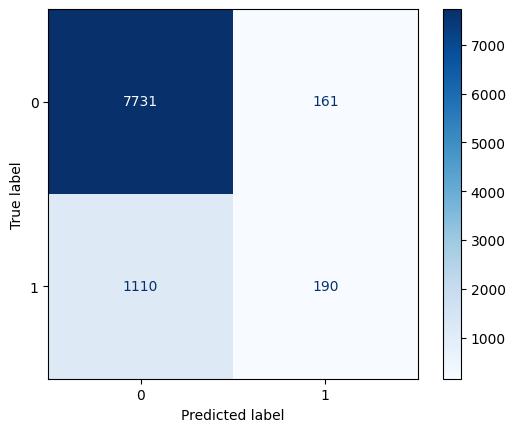

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

features = {"review": g.ndata["feature"]}
logits = model(g, features)["review"]
test_mask = g.ndata["test_mask"].to(bool)
labels = g.ndata["label"][test_mask].cpu()
pred = logits.argmax(1)[test_mask].cpu()

cm = confusion_matrix(labels, pred)
cm = ConfusionMatrixDisplay(cm)
cm.plot(cmap="Blues")

